In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
import joblib
import tabulate as tb
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import Huber
from tensorflow.keras import Sequential, layers, optimizers, losses
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [22]:
CSV_PATH = './../data/AAPL.csv'
DATE_COL = 'Date'

SEQ_LENGTH = 90
BATCH_SIZE = 32
LEARNING_RATE = 0.001
EPOCHS = 100
VAL_SPLIT = 0.1

FEATURES = [
    'Open', 'High', 'Low', 'Close', 'Volume',
    'rsi', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9',
    'BBL_20_2.0_2.0','BBM_20_2.0_2.0','BBU_20_2.0_2.0','BBB_20_2.0_2.0','BBP_20_2.0_2.0',
    'ema_10','ema_20','ema_50','atr','stoch_k','stoch_d'
]

TARGET = 'direction'

TRAINING_RANGE = [('2023-01-01', '2025-08-30')]
TESTING_RANGE = [('2025-09-01', '2025-11-04')]

In [23]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [24]:
df = pd.read_csv(CSV_PATH, parse_dates=[DATE_COL])
df = df.sort_values(DATE_COL).reset_index(drop=True)
df = df[[DATE_COL] + FEATURES + [TARGET]]
df.dropna(inplace=True)

feature_data = df[FEATURES]
target_data = df[[TARGET]].values

print(tb.tabulate(feature_data[:5], headers=FEATURES, tablefmt='psql'))
print(tb.tabulate(target_data[:5], headers=[TARGET], tablefmt='psql'))

+----+----------+----------+----------+----------+-------------+---------+----------------+-----------------+-----------------+------------------+------------------+------------------+------------------+------------------+----------+----------+----------+-----------+-----------+-----------+
|    |     Open |     High |      Low |    Close |      Volume |     rsi |   MACD_12_26_9 |   MACDh_12_26_9 |   MACDs_12_26_9 |   BBL_20_2.0_2.0 |   BBM_20_2.0_2.0 |   BBU_20_2.0_2.0 |   BBB_20_2.0_2.0 |   BBP_20_2.0_2.0 |   ema_10 |   ema_20 |   ema_50 |       atr |   stoch_k |   stoch_d |
|----+----------+----------+----------+----------+-------------+---------+----------------+-----------------+-----------------+------------------+------------------+------------------+------------------+------------------+----------+----------+----------+-----------+-----------+-----------|
|  0 | 0.90975  | 0.9325   | 0.855573 | 0.857449 | 4.28579e+08 | 44.2206 |      0.0242751 |     -0.00599352 |       0.030268

In [25]:
X, y = [], []
dates = []
for i in range(SEQ_LENGTH, len(feature_data)):
    tmp = feature_data[i - SEQ_LENGTH:i]
    X.append(tmp)
    dates.append(df[DATE_COL].values[i])
    y.append(target_data[i])

X, y = np.array(X), np.array(y)

print(f"Feature data shape: {X.shape}")
print(f"Target data shape: {y.shape}")

Feature data shape: (6360, 90, 20)
Target data shape: (6360, 1)


In [26]:
def find_closest_date_index(dates_array, target_date):
    target_date = np.datetime64(target_date)
    index = np.argmin(np.abs(dates_array - target_date))
    return index

def get_samples_in_range(df, start_date, end_date):
    beg, end = find_closest_date_index(dates, start_date), find_closest_date_index(dates, end_date)
    _x, _y = X[beg:end+1], y[beg:end+1]
    return _x, _y, beg, end

# train_beg, train_end = find_closest_date_index(dates, TRAINING_RANGE[0]), find_closest_date_index(dates, TRAINING_RANGE[1])
# test_beg, test_end = find_closest_date_index(dates, TESTING_RANGE[0]), find_closest_date_index(dates, TESTING_RANGE[1])
# print(f"Training: beg_idx={train_beg} -> beg={dates[train_beg]} || end_idx={train_end} -> end={dates[train_end]}")
# print(f"Testing:  beg_idx={test_beg} -> beg={dates[test_beg]} || end_idx={test_end} -> end={dates[test_end]}")
X_train_val, y_train_val = [], []
for beg, end in TRAINING_RANGE:
    _x, _y, _, _ = get_samples_in_range(df, beg, end)
    X_train_val.extend(_x)
    y_train_val.extend(_y)

split_index = int(len(X_train_val) * (1 - VAL_SPLIT))
X_train, y_train = X_train_val[:split_index], y_train_val[:split_index]
X_val, y_val = X_train_val[split_index:], y_train_val[split_index:]
X_test, y_test = [], []
test_dates = []
for beg, end in TESTING_RANGE:
    _x, _y, d_beg, d_end = get_samples_in_range(df, beg, end)
    X_test.extend(_x)
    y_test.extend(_y)
    test_dates.extend(dates[d_beg:d_end+1])
    
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

feature_scaler = StandardScaler()#MinMaxScaler()
feature_scaler.fit(X_train.reshape(-1, X_train.shape[-1]))
X_train = feature_scaler.transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_val = feature_scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
X_test = feature_scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

print(tb.tabulate(X_train[0][:5], headers=FEATURES, tablefmt='psql'))

print(pd.DataFrame(y_train).value_counts(normalize=True))

X_train shape: (601, 90, 20), y_train shape: (601, 1)
X_val shape: (67, 90, 20), y_val shape: (67, 1)
X_test shape: (45, 90, 20), y_test shape: (45, 1)
+-----------+-----------+-----------+-----------+-----------+-----------+----------------+-----------------+-----------------+------------------+------------------+------------------+------------------+------------------+-----------+-----------+-----------+-----------+-----------+-----------+
|      Open |      High |       Low |     Close |    Volume |       rsi |   MACD_12_26_9 |   MACDh_12_26_9 |   MACDs_12_26_9 |   BBL_20_2.0_2.0 |   BBM_20_2.0_2.0 |   BBU_20_2.0_2.0 |   BBB_20_2.0_2.0 |   BBP_20_2.0_2.0 |    ema_10 |    ema_20 |    ema_50 |       atr |   stoch_k |   stoch_d |
|-----------+-----------+-----------+-----------+-----------+-----------+----------------+-----------------+-----------------+------------------+------------------+------------------+------------------+------------------+-----------+-----------+-----------+---

In [27]:
def create_financial_model(seq_length, feature_count, learning_rate):
    inputs = layers.Input(shape=(seq_length, feature_count))

    x = layers.LSTM(96, return_sequences=True, recurrent_dropout=0.2)(inputs)
    x = layers.LayerNormalization()(x)
    x = layers.LSTM(96, return_sequences=False)(x)
    x = layers.LayerNormalization()(x)
    
    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.Dense(64, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(
        optimizer=optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model


model = create_financial_model(SEQ_LENGTH, len(FEATURES), LEARNING_RATE)

In [28]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
]

history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100


19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - accuracy: 0.5092 - loss: 0.8070 - val_accuracy: 0.5672 - val_loss: 0.7206 - learning_rate: 0.0010
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.5491 - loss: 0.7215 - val_accuracy: 0.5672 - val_loss: 0.7376 - learning_rate: 0.0010
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.5691 - loss: 0.7092 - val_accuracy: 0.5075 - val_loss: 0.7323 - learning_rate: 0.0010
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.5707 - loss: 0.6771 - val_accuracy: 0.4030 - val_loss: 0.7380 - learning_rate: 0.0010
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.6123 - loss: 0.6628 - val_accuracy: 0.4030 - val_loss: 0.7463 - learning_rate: 0.0010
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.5707 - loss: 0.6907 - val_accuracy: 0.4030 - val_loss: 0.7642 - learning_rate: 0.0010
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.6007 - loss: 0.6708 - val_accuracy

In [ ]:
pred_probs = model.predict(X_test)
pred_labels = (pred_probs > 0.5).astype(int).flatten()
y_true = y_test.flatten()

acc = accuracy_score(y_true, pred_labels)
f1 = f1_score(y_true, pred_labels)

print(f"Accuracy:  {acc:.3f}")
print(f"F1 Score:  {f1:.3f}")
print("Confusion Matrix:")
print(confusion_matrix(y_true, pred_labels))

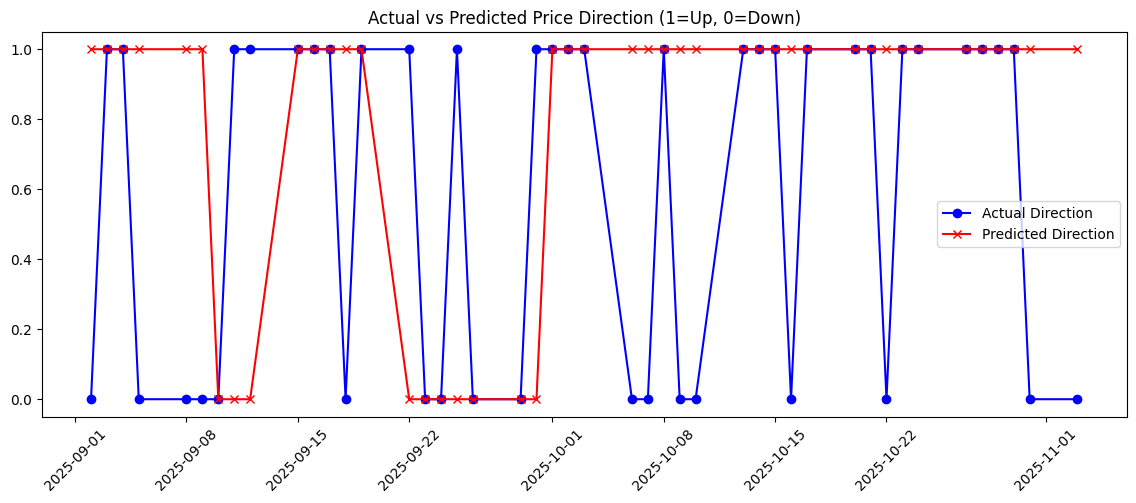

In [ ]:
dates = test_dates
plt.figure(figsize=(14, 5))
plt.plot(dates, y_true, label='Actual Direction', color='blue', marker='o')
plt.plot(dates, pred_labels, label='Predicted Direction', color='red', marker='x')
plt.title('Actual vs Predicted Price Direction (1=Up, 0=Down)')
plt.xticks(rotation=45) 
plt.legend()
plt.show()